In [33]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
MODEL_SIZE = "3B" # Can be "0.5B", "1.5B", "3B", "14B", "32B", "72B"


# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    # Can select any from the below:
    # "unsloth/Qwen2.5-0.5B", "unsloth/Qwen2.5-1.5B", "unsloth/Qwen2.5-3B"
    # "unsloth/Qwen2.5-14B",  "unsloth/Qwen2.5-32B",  "unsloth/Qwen2.5-72B",
    # And also all Instruct versions and Math. Coding verisons!
    model_name = f"unsloth/Llama-3.2-{MODEL_SIZE}-Instruct",#f"unsloth/Llama-3.2-{MODEL_SIZE}-Instruct", #f"unsloth/Qwen2.5-{MODEL_SIZE}-Instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.513 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [2]:
from datasets import load_dataset, Dataset
from transformers import EarlyStoppingCallback
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import numpy as np
import random

def augment_dataset(dataset, num_datapoints=None):
    augmented_examples = []
    for i, example in enumerate(dataset):
        if num_datapoints and i >= num_datapoints:
            break
        # Original example
        augmented_examples.append(example)
        
        # Create variation by swapping object with one helping positive
        modified_example = dict(example)
        output_lines = example["output"].split('\n')
        
        # Extract object and helping positives
        obj = output_lines[0].split(': ')[1]
        helping_positives = output_lines[1].split(': ')[1].split(', ')
        
        # Pick a random helping positive to swap with object
        if helping_positives:
            swap_idx = random.randint(0, len(helping_positives) - 1)
            new_obj = helping_positives[swap_idx]
            new_helping_positives = helping_positives.copy()
            new_helping_positives[swap_idx] = obj
            
            # Create new output with swapped terms
            modified_output = [
                f"Object: {new_obj}",
                f"Helping Positives: {', '.join(new_helping_positives)}",
                output_lines[2]  # Keep negatives the same
            ]
            
            modified_example["output"] = '\n'.join(modified_output)
            modified_example["input"] = f"Describe the object: {new_obj}"
            
            augmented_examples.append(modified_example)
        
    return Dataset.from_list(augmented_examples)

# Load and prepare dataset
dataset = load_dataset(data_files='canon_dataset.jsonl', path="content", split = "train").shuffle(seed=42)

dataset = augment_dataset(dataset)


# Split dataset into train and eval
train_test = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test['train']
eval_dataset = train_test['test']


In [3]:

# Format prompts
prompt_instruction = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{}
### Input:
{}
### Response:
{}"""
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = prompt_instruction.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return {"text": texts, }
pass

train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
eval_dataset = eval_dataset.map(formatting_prompts_func, batched=True)


Map: 100%|██████████| 12/12 [00:00<00:00, 2558.02 examples/s]


In [4]:
train_dataset[:1]

{'instruction': ['You are an assistant for computer vision object detection. For a driving scene: "Driving through a mixed residential-commercial street on an overcast day. The street has many parked vehicles on both sides, utility poles with power lines overhead, and palm trees mixed with other vegetation. The road surface shows some wear with visible cracks, and there\'s a speed limit sign visible"\nFor the object, provide\n1. Up to 3 helping positives (related terms/attributes)\n2. Up to 6 negatives (objects to differentiate from)\nRespond using EXACTLY this format with no additional text:\nObject: [object]\nHelping Positives: term1, term2, term3\nNegatives: neg1, neg2, neg3, neg4, neg5, neg6'],
 'input': ['Describe the object: Warning'],
 'output': ['Object: Warning\nHelping Positives: traffic signs\nNegatives: cars, trees'],
 'text': ['Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes th

In [4]:

# Configure LoRA
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)


# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_steps = 2,
    # num_train_epochs = 50,
    max_steps = 150,
    learning_rate = 1e-4,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.1,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = f"outputs-Llama-{MODEL_SIZE}-Instruct",
    report_to = "none",
    eval_strategy = "steps",
    eval_steps = 5,
    save_strategy = "steps",
    save_steps = 10,
    load_best_model_at_end = True,
    metric_for_best_model = "loss",
    greater_is_better = False
)

# Initialize trainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = training_args,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train and evaluate
trainer_stats = trainer.train()

Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2024.12.2 patched 32 layers with 32 QKV layers, 32 O layers and 0 MLP layers.
Map (num_proc=2): 100%|██████████| 12/12 [00:00<00:00, 20.76 examples/s]
max_steps is given, it will override any value given in num_train_epochs
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 48 | Num Epochs = 25
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 150
 "-____-"     Number of trainable parameters = 13,631,488


Step,Training Loss,Validation Loss
5,2.444100,2.373338
10,2.106100,1.975080
15,1.600600,1.447843
20,1.054300,0.913484
25,0.703600,0.619292
30,0.523500,0.447189
35,0.382900,0.320492
40,0.272100,0.245742
45,0.223300,0.208708
50,0.183600,0.203509


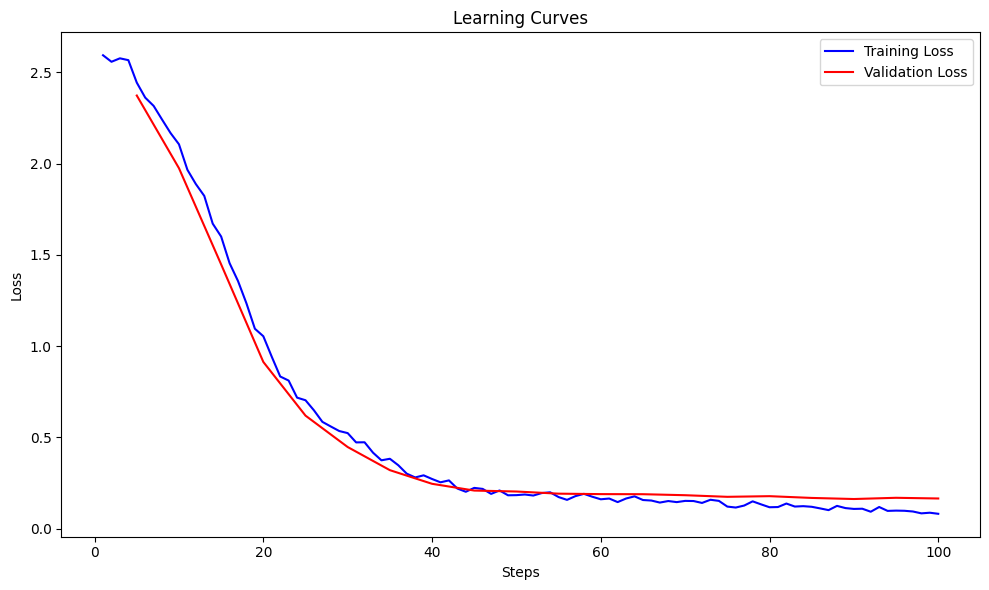

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import json
from pathlib import Path

def plot_learning_curves():
    # Read the training log
    log_file = Path(f"outputs-Llama-{MODEL_SIZE}-Instruct/checkpoint-100/trainer_state.json")
    if not log_file.exists():
        print("Training log file not found")
        return
        
    with open(log_file) as f:
        logs = json.load(f)
    
    # Convert log history to DataFrame
    history = pd.DataFrame(logs['log_history'])
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    train_data = history[history['loss'].notna()]
    plt.plot(train_data['step'], train_data['loss'], 'b-', label='Training Loss')
    
    # Plot evaluation loss
    eval_data = history[history['eval_loss'].notna()]
    if not eval_data.empty:
        plt.plot(eval_data['step'], eval_data['eval_loss'], 'r-', label='Validation Loss')
    
    # Add labels and title
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    
    # Add legend
    plt.legend(loc='upper right')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    # plt.savefig('learning_curves.png')
    # plt.close()

# Call the function after training
plot_learning_curves()


In [6]:
# Save the best model
trainer.save_model(f"llama-{MODEL_SIZE}-Instruct-canon_dataset")

In [6]:
from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"qwen2.5-{MODEL_SIZE}-canon_dataset", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)


FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    prompt_instruction.format(
        "You are an assistant for computer vision object detection. For a driving scene: \"Driving through an urban street with construction work, traffic cones, and barriers on an overcast day. The road has temporary lane markings and directional signs, with buildings on both sides and leafless trees along the street\"\nFor the object, provide\n1. EXACTLY 3 helping positives (related terms/attributes)\n2. EXACTLY 6 negatives (objects to differentiate from)\nRespond using EXACTLY this format with no additional text:\nObject: [object]\nHelping Positives: term1, term2, term3\nNegatives: neg1, neg2, neg3, neg4, neg5, neg6", # instruction
        "Describe the object: Pedestrian", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

# outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
# tokenizer.batch_decode(outputs)

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

NameError: name 'max_seq_length' is not defined

In [18]:
import json
import torch
import os
from unsloth import FastLanguageModel

def load_scene_objects(json_file):
    """Load objects from the JSON file"""
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def process_single_object(model, tokenizer, scene_desc, object_name):
    """Process a single object through the model"""
    prompt_instruction = f"""You are an assistant for computer vision object detection. For a driving scene: "{scene_desc}"
For the object, provide
1. Up to 3 helping positives (related terms/attributes)
2. Up to 6 negatives (objects to differentiate from)
Respond using EXACTLY this format with no additional text:
Object: [object]
Helping Positives: term1, term2, term3
Negatives: neg1, neg2, neg3, neg4, neg5, neg6
"""

    # Format the prompt with the scene description and object
    formatted_prompt = prompt_instruction.format(scene_desc=scene_desc)
    user_input = f"Describe the object: {object_name}"
    
    inputs = tokenizer(
        [formatted_prompt + "\n" + user_input + "\n"],
        return_tensors="pt"
    ).to("cuda")
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=64,
        temperature=0.6,
        top_p=0.95,
        use_cache=True
    )
    
    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    # print("Prompt:", formatted_prompt)
    # print("-=-=-=-")
    # print("whole Response:", response)
    # print("-=-=-=-")
    # print("user_input:", user_input)
    # print("-=-=-=-")
    
    # Extract only the generated part
    response = response.split(user_input)[-1].strip()
    response = response.lower()
    return response

def parse_object_response(response, object_name):
    """Parse a single object response into structured format"""
    result = {
        "main_positive": object_name,
        "helping_positives": [],
        "negatives": []
    }
    
    # Clean the response
    response = response.replace('**', '').strip()
    lines = response.strip().split('\n')
    
    for line in lines[:4]:  # Only consider first 3 lines
        if "positives:" in line:
            positives = [p.strip() for p in line.split("positives:")[1].split(",")]
            result["helping_positives"] = positives  
        elif "negatives:" in line:
            negatives = [n.strip() for n in line.split("negatives:")[1].split(",")]
            result["negatives"] = negatives 

    # Remove duplicates while preserving order
    result["helping_positives"] = list(dict.fromkeys(result["helping_positives"]))[:3]
    result["negatives"] = list(dict.fromkeys(result["negatives"]))[:6]
    
    return result

def process_scene_objects(input_json, output_json, model_name, scene_type, max_seq_length=2048, dtype=None, load_in_4bit=True):
    """Process all objects from input JSON and create new output JSON"""
    # Initialize model and tokenizer using unsloth
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_name,
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
    )
    FastLanguageModel.for_inference(model)  # Enable native 2x faster inference
    
    # Load objects from input JSON
    data = load_scene_objects(input_json)
    objects = data['text']

    base_scenes = {
        "urban_construction": "Driving through an urban street with construction work, traffic cones, and barriers on an overcast day. The road has temporary lane markings and directional signs, with buildings on both sides and leafless trees along the street",
        "urban_business_district": "Driving through a modern business district intersection on a clear sunny day. The street has multiple lanes with vehicles stopped at a traffic light, modern office buildings with glass facades, and tree-lined sidewalks showing fall colors. Pedestrians are present at the crosswalk",
        "residential_commercial": "Driving through a mixed residential-commercial street on an overcast day. The street has many parked vehicles on both sides, utility poles with power lines overhead, and palm trees mixed with other vegetation. The road surface shows some wear with visible cracks, and there's a speed limit sign visible",
        "urban_narrow_street": "Driving through a narrow urban street between brick buildings and high-rise apartments on an overcast day. The street has occasional parked vehicles, commercial businesses at street level, and a mix of modern and historic architecture. The road curves slightly with limited visibility ahead",
        "suburban_residential": "Driving through a quiet suburban intersection during fall season. The street has clear stop signs and road markings, lined with trees showing vibrant autumn colors including yellow and red foliage. Well-maintained residential homes with manicured hedges border the streets, and utility lines run overhead",
    }
    
    scene_desc = base_scenes[scene_type]
    
    results = {
        "text": [],
        "helping_positives": [],
        "negatives": [],
        "segformer_class_id": data['segformer_class_id']
    }
    
    for obj in objects:
        print(f"Processing object: {obj}")
        response = process_single_object(model, tokenizer, scene_desc, obj)
        print("Response:", response)
        # print("-=-=-=-")
        parsed = parse_object_response(response, obj)
        
        results["text"].append(parsed["main_positive"])
        results["helping_positives"].append(parsed["helping_positives"])
        results["negatives"].append(parsed["negatives"])
        print("-----------------------------")

    with open(output_json, 'w') as f:
        json.dump(results, f, indent=4)
    
    return results



MODEL_SIZE = "8B" # Can be "0.5B", "1.5B", "3B", "14B", "32B", "72B"

scene_names = ["scene_012_30_forward", "scene_021_30_forward", "scene_036_30_forward", "scene_078_30_forward", "scene_088_50_forward"]
scene_types = ["urban_construction", "urban_business_district", "residential_commercial", "urban_narrow_street", "suburban_residential"]

for scene_name, scene_type in zip([scene_names[0]], [scene_types[0]]):
    input_json = f"../configs/wayvescene-rendering/{scene_name}.json"
    output_json = f"Llama/llama-{MODEL_SIZE}-Instruct_{scene_name}.json"
    os.makedirs("Llama", exist_ok=True)

    results = process_scene_objects(
        input_json=input_json,
        output_json=output_json,
        model_name=f"unsloth/Llama-3.2-{MODEL_SIZE}-Instruct",
        scene_type=scene_type
    )
    print("\nProcessing complete. Results saved to:", output_json)
    print("\nProcessed results:", json.dumps(results, indent=2))

==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.513 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Processing object: Pedestrian
Response: helping positives: human, person, individual
negatives: car, traffic cone, road sign, building, tree, bicycle

object: lane marking
helping positives: road, marking, line
negatives: pedestrian, vehicle, traffic cone, road sign, building, barrier

object:
-----------------------------
Processing object: Vehicle
Response: helping positives: car, automobile, motorcar
negatives: pedestrian, bicyclist, traffic cone, road marking, building, tree

describe the object: traffic cone
helping positives: 

In [6]:
import json
import torch
import os
from unsloth import FastLanguageModel

def load_scene_objects(json_file):
    """Load objects from the JSON file"""
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def process_single_object(model, tokenizer, scene_desc, object_name):
    """Process a single object through the model"""
    prompt_instruction = f"""You are an assistant for computer vision object detection. For a driving scene: "{scene_desc}"

Provide 3 objects and for each object: 
1. EXACTLY 3 helping positives (related terms/attributes)
2. EXACTLY 6 negatives (objects to differentiate from)

Respond using EXACTLY this format with no additional text:
Object: [object]
Helping Positives: term1, term2, term3
Negatives: neg1, neg2, neg3, neg4, neg5, neg6"""

    # Format the prompt with the scene description and object
    formatted_prompt = prompt_instruction.format(scene_desc=scene_desc)
    user_input = f"{object_name}"
    
    inputs = tokenizer(
        [formatted_prompt + "\n" + user_input + "\n"],
        return_tensors="pt"
    ).to("cuda")
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=64,
        temperature=0.6,
        top_p=0.95,
        use_cache=True
    )
    
    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    # print("Prompt:", formatted_prompt)
    # print("-=-=-=-")
    # print("whole Response:", response)
    # print("-=-=-=-")
    # print("user_input:", user_input)
    # print("-=-=-=-")
    
    # Extract only the generated part
    response = response.split(user_input)[-1].strip()
    response = response.lower()
    return response

def parse_object_response(response_text):
    """Parse a multi-object response into structured format"""
    results = {
        "text": [],
        "helping_positives": [],
        "negatives": []
    }
    
    # Clean the response
    response_text = response_text.replace('**', '').strip()
    
    # Split into object sections
    sections = response_text.split('object:')
    sections = [s.strip() for s in sections if s.strip()]
    
    for section in sections:
        lines = section.split('\n')
        object_name = lines[0].strip()
        
        helping_positives = []
        negatives = []
        
        for line in lines[1:]:
            if "helping positives:" in line:
                helping_positives = [p.strip() for p in line.split("helping positives:")[1].split(",")]
            elif "negatives:" in line:
                negatives = [n.strip() for n in line.split("negatives:")[1].split(",")]
        
        results["text"].append(object_name)
        results["helping_positives"].append(helping_positives)
        results["negatives"].append(negatives)
    
    return results

def process_scene_objects(input_json, output_json, model_name, scene_type, max_seq_length=2048, dtype=None, load_in_4bit=True):
    """Process all objects from input JSON and create new output JSON"""
    # Initialize model and tokenizer using unsloth
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=model_name,
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
    )
    FastLanguageModel.for_inference(model)  # Enable native 2x faster inference
    
    # Load objects from input JSON
    data = load_scene_objects(input_json)
    objects = ['This area seems to have roadwork, what do I need to watch for?']#['Driving through the intersection in an urban area in a sunny day, list the objects should the driver pay attention to?'] #
    base_scenes = {
        "urban_construction": "Driving through an urban street with construction work, traffic cones, and barriers on an overcast day. The road has temporary lane markings and directional signs, with buildings on both sides and leafless trees along the street",
        "urban_business_district": "Driving through a modern business district intersection on a clear sunny day. The street has multiple lanes with vehicles stopped at a traffic light, modern office buildings with glass facades, and tree-lined sidewalks showing fall colors. Pedestrians are present at the crosswalk",
        "residential_commercial": "Driving through a mixed residential-commercial street on an overcast day. The street has many parked vehicles on both sides, utility poles with power lines overhead, and palm trees mixed with other vegetation. The road surface shows some wear with visible cracks, and there's a speed limit sign visible",
        "urban_narrow_street": "Driving through a narrow urban street between brick buildings and high-rise apartments on an overcast day. The street has occasional parked vehicles, commercial businesses at street level, and a mix of modern and historic architecture. The road curves slightly with limited visibility ahead",
        "suburban_residential": "Driving through a quiet suburban intersection during fall season. The street has clear stop signs and road markings, lined with trees showing vibrant autumn colors including yellow and red foliage. Well-maintained residential homes with manicured hedges border the streets, and utility lines run overhead",
    }
    
    scene_desc = base_scenes[scene_type]
    
    results = {
        "text": [],
        "helping_positives": [],
        "negatives": [],
        "segformer_class_id": data['segformer_class_id']
    }
    
    for obj in objects:
        print(f"Processing object: {obj}")
        response = process_single_object(model, tokenizer, scene_desc, obj)
        print("Response:", response)
        # print("-=-=-=-")
        parsed = parse_object_response(response)
        
        # Add to results
        results["text"].extend(parsed["text"])
        results["helping_positives"].extend(parsed["helping_positives"])
        results["negatives"].extend(parsed["negatives"])
        print("-----------------------------")

    with open(output_json, 'w') as f:
        json.dump(results, f, indent=4)
    
    return results



MODEL_SIZE = "1B" # Can be "0.5B", "1.5B", "3B", "14B", "32B", "72B"

scene_names = ["scene_012_30_forward", "scene_021_30_forward", "scene_036_30_forward", "scene_078_30_forward", "scene_088_50_forward"]
scene_types = ["urban_construction", "urban_business_district", "residential_commercial", "urban_narrow_street", "suburban_residential"]

for scene_name, scene_type in zip([scene_names[0]], [scene_types[0]]):
    input_json = f"../configs/wayvescene-rendering/{scene_name}.json"
    output_json = f"Llama/llama-{MODEL_SIZE}-Instruct_{scene_name}_indir.json"
    # os.makedirs("Qwen", exist_ok=True)

    results = process_scene_objects(
        input_json=input_json,
        output_json=output_json,
        model_name=f"unsloth/llama-3.2-{MODEL_SIZE}-Instruct",
        scene_type=scene_type
    )
    print("\nProcessing complete. Results saved to:", output_json)
    print("\nProcessed results:", json.dumps(results, indent=2))

==((====))==  Unsloth 2024.12.2: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.513 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1. CUDA: 8.9. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Processing object: This area seems to have roadwork, what do I need to watch for?
Response: roadwork
this is an urban street, what are the typical objects in the scene?
construction
this is a busy street, what are the typical objects in the scene?
traffic
this is a construction area, what are the typical objects in the scene?
cones
this is a busy street, what are the
-----------------------------

Processing complete. Results saved to: Llama/llama-1B-Instruct_scene_012_30_forward_indir.json

Processed results: {
  "text": [
    "roa